In [72]:
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline
from scipy import interpolate, spatial,signal
import scipy.io
from astropy.cosmology import Planck15 as cosmo

In [73]:
# define the image grid
image_size_in_arcsec = 5.0
N_pixel = 400

# construct a regular image grid spanning image_size_in_arcsec on the side and centered on zero but convert to radians.
# xim, yim = ...
xspace = np.linspace(-image_size_in_arcsec/2,image_size_in_arcsec/2,N_pixel) * np.pi/3600./180.
xim,yim = np.meshgrid(xspace,xspace)


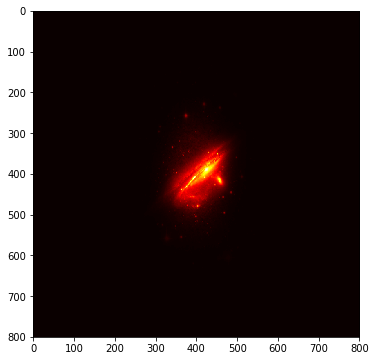

In [74]:
# define the source
im_src_field = 2.0
Ns = 800
x_sr_grid = np.linspace(-im_src_field/2.0,im_src_field/2.0,Ns) * np.pi/3600./180.
y_sr_grid = np.linspace(-im_src_field/2.0,im_src_field/2.0,Ns) * np.pi/3600./180.

mat_contents = scipy.io.loadmat("dat1.mat")
src_im = mat_contents['source_im']

plt.figure(figsize=(6, 6))
plt.imshow(src_im,cmap="hot")

In [75]:
# define deflection angle calculation function

def cart2pol(x,y):
    r = np.sqrt(x**2. + y**2.)
    theta = np.arctan2(y,x)
    return r, theta

def pol2cart(r,theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x,y

def Beta(xim,yim,pars):
    Msun= 1.98892e30
    c = 2.998E8
    G = 6.67259E-11
    pc = 3.0857E16
    Mpc = pc * 1.0e6

    Zlens = 0.5
    Zsource = 2.0
    Dd = cosmo.angular_diameter_distance(Zlens).value
    Dds= cosmo.angular_diameter_distance_z1z2(Zlens,Zsource).value
    Ds = cosmo.angular_diameter_distance(Zsource).value

    REIN = pars[0]
    sigma = np.sqrt(299800000.0**2/(4.0*np.pi) * REIN *np.pi/180./3600. * Ds/Dds)
    M = (np.pi*(sigma**2)*(REIN*np.pi/180/3600)*Dd*Mpc)/G/Msun

    elp = pars[1]
    angle = pars[2]
    xlens = pars[3] * np.pi /180.0/3600.0
    ylens = pars[4] * np.pi /180.0/3600.0
    
    ximage, yimage = xim.copy(), yim.copy()

    f = 1. - elp
    fprime = np.sqrt(1. - f**2.)

    Xi0 = 4*np.pi * (sigma/c)**2. * (Dd*Dds/Ds)

    ximage -= xlens
    yimage -= ylens
    
    r,theta = cart2pol(ximage,yimage)
    ximage,yimage = pol2cart(r,theta-(angle * np.pi /180))
    phi = np.arctan2(yimage,ximage)

    dxs = -(Xi0/Dd)*(np.sqrt(f)/fprime)*np.arcsinh(np.cos(phi)*fprime/f)
    dys = -(Xi0/Dd)*(np.sqrt(f)/fprime)*np.arcsin(np.sin(phi)*fprime)

    r,theta = cart2pol(dxs,dys)
    alphax,alphay = pol2cart(r,theta+(angle*np.pi/180))
    
    xsr = xim + alphax
    ysr = yim + alphay

    return alphax , alphay , xsr , ysr

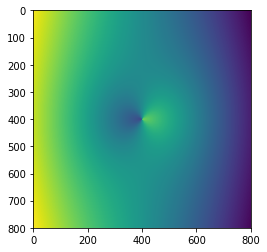

In [76]:
plt.imshow(xsr)
plt.show()

In [77]:
# ray-trace the pixels
lens_parameters = [1. , 0.2 , 30.0 , 0.0 , 0.0]
alphax , alphay , xsr , ysr = Beta(xim,yim,lens_parameters)

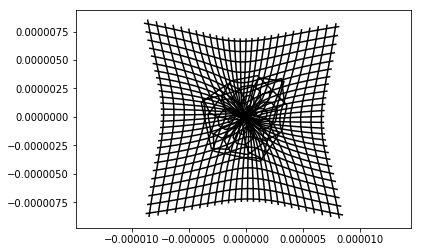

In [92]:
plt.axis('equal')
plt.plot(xsr[::15,::15],ysr[::15,::15],'k')
plt.plot(ysr[::15,::15],xsr[::15,::15],'k')
plt.show()

In [94]:
# interpolate the source at the position of ray-traced pixels to produce a lensed image.
# print(np.shape(xsr))
# print(len(xim))
print(len(x_sr_grid))
print(np.shape(src_im))
interpolator = interpolate.RectBivariateSpline(x_sr_grid,y_sr_grid,src_im,kx=1,ky=1)

# lensed_image = np.zeros((N_pixel,N_pixel))
# for i in range(N_pixel):
#     for j in range(N_pixel):
#         lensed_image[i,j] = interpolator(xsr[i,j],ysr[i,j])

lensed_image = interpolator.ev(xsr.ravel(),ysr.ravel()).reshape([N_pixel,N_pixel])
                                                      

800
(800, 800)


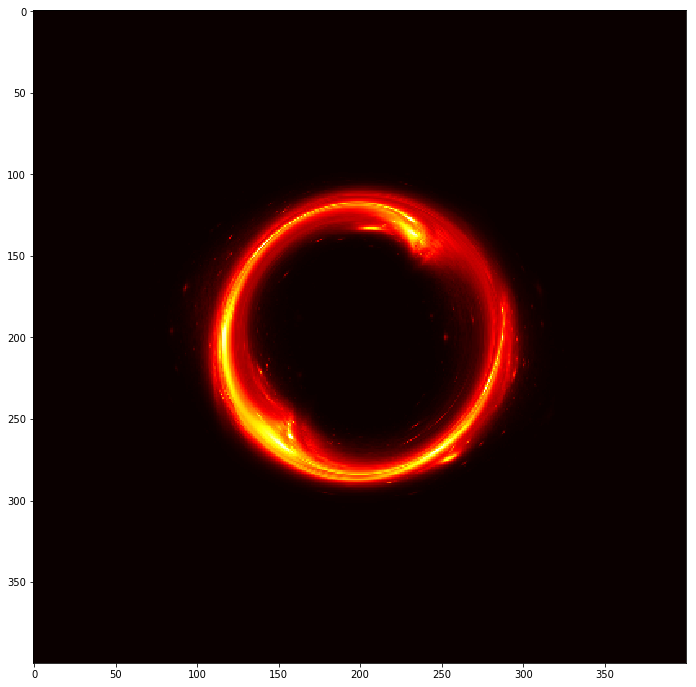

In [80]:
plt.figure(figsize=(12, 12))
plt.imshow(lensed_image,cmap="hot")

## Calculate the deflection angles numerically from the kappa map and compare with the analytic deflection angles given above.

In [81]:
def SIE_kappa(lens_parameters,XIM,YIM):
    REIN , elp , angle , XLENS , YLENS = lens_parameters
    rc = 0.
    Msun= 1.98892e30
    c = 2.998E8
    G = 6.67259E-11
    pc = 3.0857E16
    Mpc = pc * 1.0e6
    Zlens = 0.5
    Zsource = 2.0
    Dd = cosmo.angular_diameter_distance(Zlens).value
    Dds= cosmo.angular_diameter_distance_z1z2(Zlens,Zsource).value
    Ds = cosmo.angular_diameter_distance(Zsource).value
    sigma = np.sqrt(299800000.0**2/(4.0*np.pi) * REIN *np.pi/180./3600. * Ds/Dds)
    theta = angle*np.pi/180
    [RHO,TH]=cart2pol(XIM,YIM)
    [XIM,YIM] = pol2cart(RHO,TH-theta)
    [RHO,TH]=cart2pol(XLENS,YLENS)
    [XLENS,YLENS] = pol2cart(RHO,TH-theta)
    r = np.sqrt((XIM-XLENS*np.pi/180./3600.)**2+((YIM-YLENS*np.pi/180./3600.)*(1-elp))**2) 
    R_ein = 4.*np.pi * (sigma/c)**2 * Dds/Ds;
    kappa = np.sqrt(1-elp) * R_ein/(2.*np.sqrt(r**2+rc**2));
    return kappa

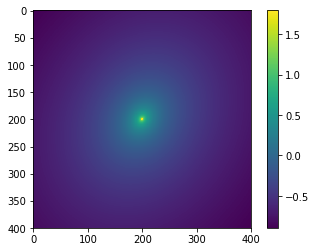

In [82]:
K = SIE_kappa(lens_parameters,xim,yim)
plt.imshow(np.log10(K))
plt.colorbar()


In [119]:
#convolve theta part of alpha integral with kappa part
def numerical_deflection_angles(xin,yin,K):
    dtheta = (xin+1.j*yin)/(xin**2+yin**2)
    result = signal.convolve(K,dtheta,mode='same')*(image_size_in_arcsec*np.pi/3600. /180./N_pixel)**2
    
    return xin-np.real(result)/np.pi, yin-np.imag(result)/np.pi

In [120]:
xsr2,ysr2 = numerical_deflection_angles(xim,yim,K)
lensed_image2 = interpolator.ev(xsr2.ravel(),ysr2.ravel()).reshape([N_pixel,N_pixel])

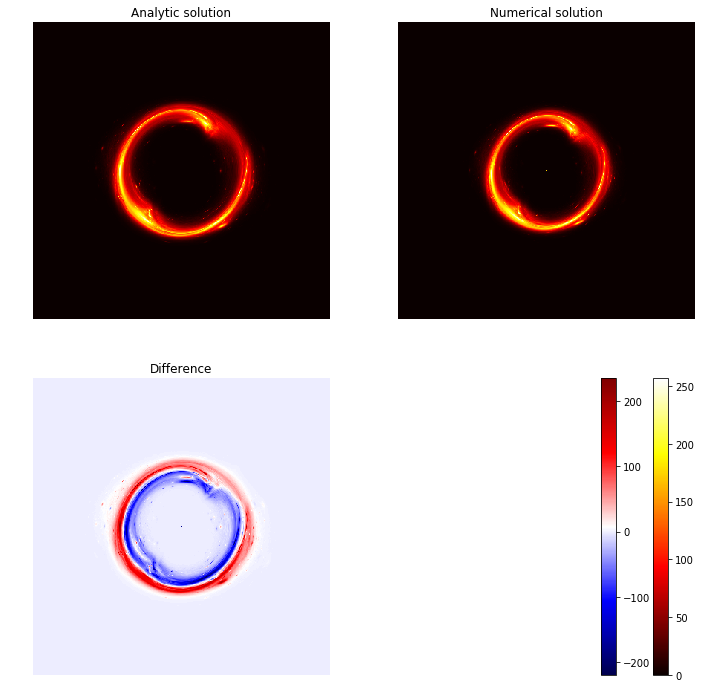

In [121]:
fig,ax = plt.subplots(2,2,figsize=(12,12))
ax[0,0].imshow(lensed_image,cmap='hot')
ax[0,0].set_title('Analytic solution')
im1= ax[0,1].imshow(lensed_image2,cmap='hot')
fig.colorbar(im1)
ax[0,1].set_title('Numerical solution')
im2= ax[1,0].imshow(lensed_image-lensed_image2,cmap='seismic')
ax[1,0].set_title('Difference')
fig.colorbar(im2)
for i in range(2):
    for j in range(2):
        ax[i,j].axis('off')

#### What causes inconsistencies? how could this be improved?